## Stochastic gradient descent

SGD is arguably the most important and most widely used algorithm in machine learning. This notebook is in many places simply copied & pasted from the "gradient" notebook.

Normally SGD is used to minimise a loss function of the form
$$
L(w)=\frac{1}{|S|}\sum_{(x,y)\in S}L_{(x,y)}(w)
$$

**stochastic gradient descent**
1. set $t=1$
2. **while** stopping criterion not satisfied **do**
3. $\quad$ draw $z_t=(x_t,y_t)$ uniformly at random from $S$
4. $\quad$ compute $\nabla L_{z_t}(w^{(t)})$
4. $\quad$ compute learning rate $\eta_t$
5. $\quad$ set $w^{(t+1)}=w^{(t)}-\eta_t\nabla L_{z_t}(w^{(t)})$
6. $\quad$ set $t=t+1$
7. **end while**
8. output $w^{(t-1)}$


In [1]:
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from matplotlib import ticker, cm
import math
import random

Again, we define a convenience function to plot the functions we minimise. We also copy & paste the gradient descent method from the "gradient" notebook. Since gradient descent and SGD only differ in the way how the direction of change in the update is computed, we can reuse that method.

In [2]:
def plot_descent(xmin,xmax,ymin,ymax,fun,path,N=100,nbins='auto'):
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)
    X, Y = np.meshgrid(x, y)
    z=fun(X,Y)
    fig, ax = plt.subplots(figsize=(10,4))
    cs = ax.contourf(X, Y, z,cmap=cm.Reds,locator=ticker.MaxNLocator(nbins=nbins))
    if path is not None:
        ax.plot(path[:,0],path[:,1],"bo-")
    plt.axis([xmin,xmax,ymin,ymax])
    plt.show()

def gradient_descent(grad,x0,eta,steps=10):
    path=[x0]
    x=x0
    for i in range(steps):
        x=x-eta*grad(x)
        path.append(x)
    return np.array(path)

We first consider the function $$f:(x,y)\mapsto \tfrac{1}{2}(x^2+10y^2)-\tfrac{1}{10}e^{\frac{3}{10}(2x-y)}$$ For SGD we need to choose, in each step, a direction that, in expectation, points in the direction of the gradient. We achieve that by pertubing the actual gradient by a gaussian. Obviously, this only makes sense as a demonstration -- as we first compute the full gradient we do not realise any speed-ups.

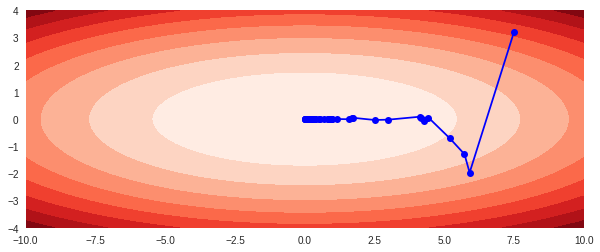

In [3]:
def fun1(X,Y):
    return 0.5*(X**2+10*Y**2)

def grad1(x):
    return np.array((x[0],10*x[1]))

def stochgrad1(x):
    sigma=1
    return grad1(x)*np.array((1+random.gauss(0,sigma),1+random.gauss(0,sigma)))

eta=0.1
x0=np.array((7.5,3.2))
path=gradient_descent(stochgrad1,x0,eta,steps=50)
plot_descent(-10,10,-4,4,fun1,path)

Compared to ordinary gradient descent, the path towards the minimum is much more wiggly. This is as expected! Also, we need many more steps.

Let's try out different learning rates. 

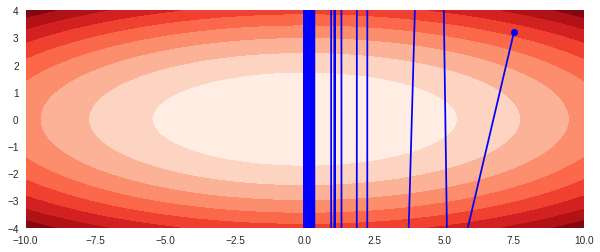

In [4]:
eta=0.2
x0=np.array((7.5,3.2))
path=gradient_descent(stochgrad1,x0,eta,steps=50)
plot_descent(-10,10,-4,4,fun1,path)

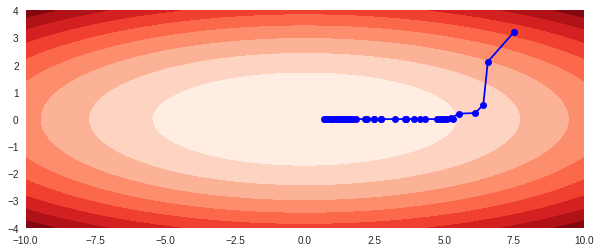

In [5]:
eta=0.05
x0=np.array((7.5,3.2))
path=gradient_descent(stochgrad1,x0,eta,steps=50)
plot_descent(-10,10,-4,4,fun1,path)

## Two local minima

Again, let's consider 
$$
f:(x,y)\mapsto \tfrac{1}{4}x^4+\tfrac{2}{3}x^3-\tfrac{15}{2}x^2+100y^2
$$
a function with two local minima. 

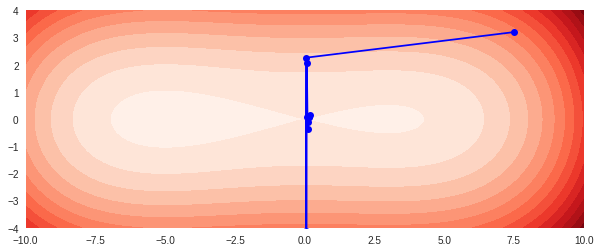

In [6]:
a,b,c=-5,0,3

def fun3(X,Y):
    return 0.25*X**4-(a+b+c)/3*X**3+0.5*(a*b+b*c+c*a)*X**2-a*b*c*X+100*Y**2

def grad3(x):
    return np.array(((x[0]-a)*(x[0]-b)*(x[0]-c),100*x[1]))

def stochgrad3(x):
    sigma=1
    return grad3(x)*np.array((1+random.gauss(0,sigma),1+random.gauss(0,sigma)))

eta=0.01
x0=np.array((7.5,3.2))
path=gradient_descent(stochgrad3,x0,eta)
plot_descent(-10,10,-4,4,fun3,path,nbins=15)

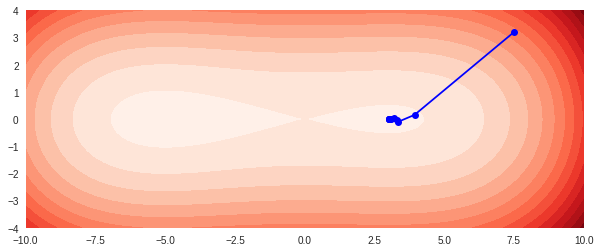

In [7]:
eta=0.01
x0=np.array((7.5,3.2))
path=gradient_descent(stochgrad3,x0,eta)
plot_descent(-10,10,-4,4,fun3,path,nbins=15)

Running SGD, from the same initial point, several times, we may end up in either of the two local minima. This should be seen as an advantage: by running the algorithm more than once we may find every better local minima.

## let's see where SGD ends up in repeated runs

We do now repeated runs of SGD and keep track of in which local minimum the algorithm ends up.

In [8]:
# local min and global min
fun3(3,0),fun3(-5,0)

(-29.25, -114.58333333333333)

<ipython-input-6-c32d19f9f455>:7: RuntimeWarning: overflow encountered in double_scalars
  return np.array(((x[0]-a)*(x[0]-b)*(x[0]-c),100*x[1]))
<ipython-input-2-e942d86d617e>:17: RuntimeWarning: invalid value encountered in subtract
  x=x-eta*grad(x)
<ipython-input-6-c32d19f9f455>:4: RuntimeWarning: invalid value encountered in double_scalars
  return 0.25*X**4-(a+b+c)/3*X**3+0.5*(a*b+b*c+c*a)*X**2-a*b*c*X+100*Y**2
<ipython-input-6-c32d19f9f455>:4: RuntimeWarning: overflow encountered in double_scalars
  return 0.25*X**4-(a+b+c)/3*X**3+0.5*(a*b+b*c+c*a)*X**2-a*b*c*X+100*Y**2


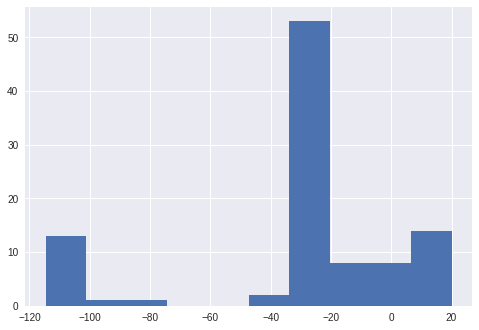

In [9]:
eta=0.01
x0=np.array((7.5,3.2))
repeats=100
results=[]
for n in range(repeats):
    path=gradient_descent(stochgrad3,x0,eta)
    results.append(fun3(*path[-1]))

results=np.array(results)
results[np.isnan(results)]=20   # get rid of overflows
results[results>=20]=20         # cap at 20
plt.hist(results)
plt.show()

The two peaks in the histogramm, between -120 and -110, and between -40 and -20, correspond to the two local minima.

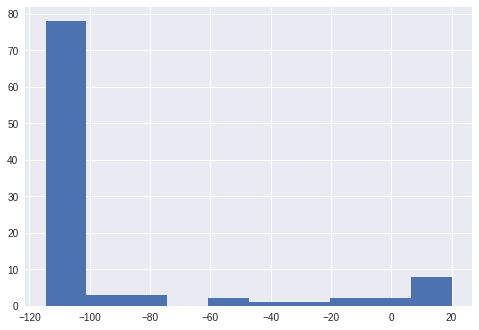

In [10]:
### same story, only start at the left
### gradient descent would end up in global min

eta=0.01
x0=np.array((-7.5,3.2))
repeats=100
results=[]
for n in range(repeats):
    path=gradient_descent(stochgrad3,x0,eta)
    results.append(fun3(*path[-1]))

results=np.array(results)
results[np.isnan(results)]=20   # get rid of overflows
results[results>=20]=20         # cap at 20
plt.hist(results)
plt.show()

## SGD and logistic regression

We now apply SGD to logistic regression. For this we first generate a random dataset.

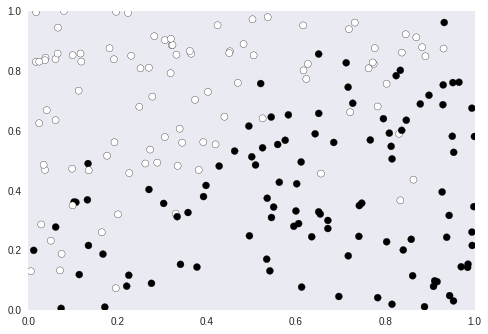

In [11]:
def logistic(z):
    return 1/(1+math.e**(-z))

def det_class(x):
    a,b=0.7,0.2
    d=a*x[0]+b-x[1]
    if random.random()<logistic(8*d):
        return 1
    return -1

def gen_samples(N):
    X=[(random.random(),random.random()) for i in range(N)]
    y=np.array([det_class(x) for x in X])
    X=np.array(X)
    return X,y

# generate data set, upper left -> class -1, lower right -> class 1

X,y=gen_samples(200)
fig, ax = plt.subplots()
ax.scatter(X[:,0],X[:,1],c=y,edgecolor='k')
ax.grid(False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

We define the logistic loss as 
$$
L(w)=\frac{1}{|S|}\sum_{(x,y)\in S}-\log\left(\frac{1}{1+e^{-y(w^Tx+b)}}\right)
$$
Compare the method <code>stoch_grad_factory</code> to the corresponding method <code>log_reg_grad_factory</code> in the gradient notebook: it's simpler in so far as that it does not sum over the whole dataset. The implementation here is not optimised for speed. In particular, in each iteration a random datapoint is chosen. A more efficient implementation would shuffle the dataset once at the beginning and then simply step through the random order of the dataset.

In [12]:
def aff_fun(W,x):
    """returns sum W_ix_i+b, where b is the last entry of W"""
    return sum(W[:-1]*x)+W[-1]

# given data set, return logistic loss by weight vector
def log_reg_factory(X,y):
    def log_reg_loss(W):
        return 1/len(X)*sum([-math.log(logistic(y[i]*aff_fun(W,X[i,:])),2) for i in range(len(X))])
    return log_reg_loss

# given data set, return sub-gradient of logistic loss 
def stoch_grad_factory(X,y):
    def subgrad(W):
        # pick random data point
        i=random.randint(0,len(X)-1)
        g0= -y[i]*X[i,0]*logistic(-y[i]*aff_fun(W,X[i,:]))
        g1= -y[i]*X[i,1]*logistic(-y[i]*aff_fun(W,X[i,:]))         
        g2= -y[i]*logistic(-y[i]*aff_fun(W,X[i,:]))
        return np.array([g0,g1,g2])/math.log(2) 
    return subgrad

sgrad=stoch_grad_factory(X,y)
for i in range(3):
    print(sgrad([1,2,3]))

[0.43933704 1.29366792 1.4340441 ]
[0.27517713 0.79793006 1.4236515 ]
[0.32136109 0.64955197 1.42010743]


In [13]:
def plot_logreg_descent(X,y,path,every_nth_step=10):
    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],c=y,edgecolor='k')
    XX=np.linspace(0,1,100)
    color="r-"  # we draw the first line in red
    count=0
    for W in path:
        if count%every_nth_step==0:
            ax.plot(XX,-(W[0]*XX+W[2])/W[1],color,alpha=0.8)
            color="b-"  # all subsequent lines in blue
        count+=1
    ax.grid(False)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

    plt.show()

Let's run SGD on this dataset. The red line marks the starting point.

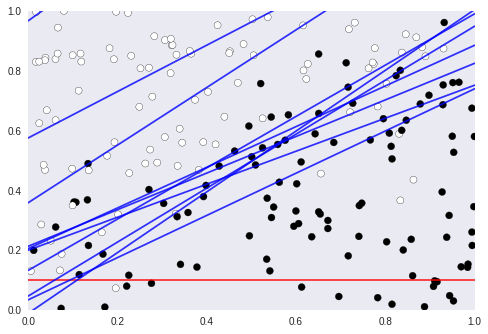

In [14]:
W0=[0,-1,0.1]
eta=0.8
path=gradient_descent(stoch_grad_factory(X,y),W0,eta,steps=200)
plot_logreg_descent(X,y,path,every_nth_step=20)

We observe: convergence is much slower compared to gradient descent, and, obviously, much more random.

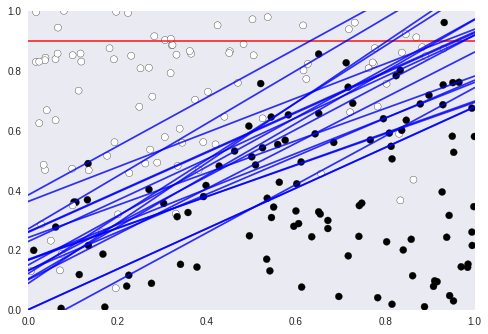

In [15]:
W0=[0,-1,0.9]
eta=1
path=gradient_descent(stoch_grad_factory(X,y),W0,eta,steps=1000)
plot_logreg_descent(X,y,path,every_nth_step=50)

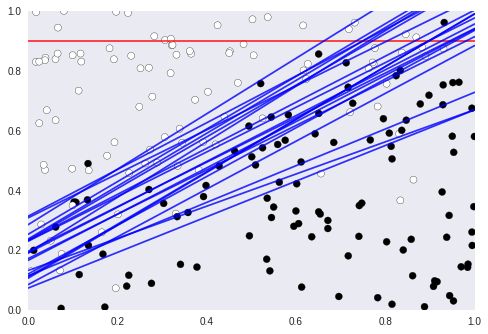

In [16]:
W0=[0,-1,0.9]
eta=1
path=gradient_descent(stoch_grad_factory(X,y),W0,eta,steps=10000)
plot_logreg_descent(X,y,path,every_nth_step=500)